# BertonGan MNIST Experiments

In [10]:
# check if in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
	import os
	sys.path.append(os.path.abspath('berton-gan'))

### Download the MNIST data

the first thing we have to do is download the MNIST dataset if it doesn't exist.

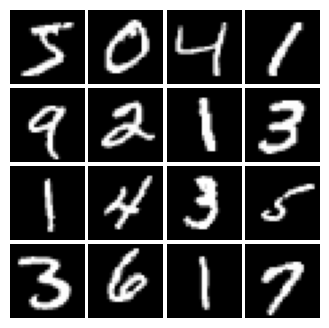

In [11]:
from src import download_mnist_data
from experiments import show_images

# download mnist data if it doesn't already exist
data = download_mnist_data()

# print some examples
k = 16
first_k_imgs = [data[i][0] for i in range(k)]
show_images(first_k_imgs, grayscale=True)

### Constructing our BertonGan

Next, we must make our BertonGan, and store it in a variable

In [12]:
from src import BertonGan

# lets make our BertonGan for mnist
berton_gan = BertonGan('mnist')

### Training the BertonGan

Next, we train our BertonGan!

In [13]:
from src import MnistLoader, train_all_at_once

TRAIN = False # set to False if you don't want to train your berton_gan

if TRAIN:
	# lets train our Berton Gan on mnist
	n, N, epochs = 3, 16, 5
	train_loader = MnistLoader(n, N)
	train_all_at_once(berton_gan, train_loader, epochs=epochs, verbose=True, optimizer_options={'lr': 1e-2})


### Loading a BertonGan

If we didn't train one, we should load in a BertonGan, so our weights aren't random

In [14]:
from experiments.utils import load_berton_gan

if not TRAIN:
	# load our bertongan from .pt files
	berton_gan = load_berton_gan('mnist_experiment_herb_7/46')


### Pick a random index

To generate an image we should first pick a random image in our dataset

label is a 5


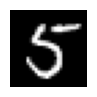

In [15]:
import torch

# pick a random index
random_idx = torch.randint(0, len(data), (1,))[0]

# get the image and label out
img, label = data[random_idx]

# show the image
print(f'label is a {label}')
show_images([img], grayscale=True)


latent vector tensor([-0.8638, -1.1570])


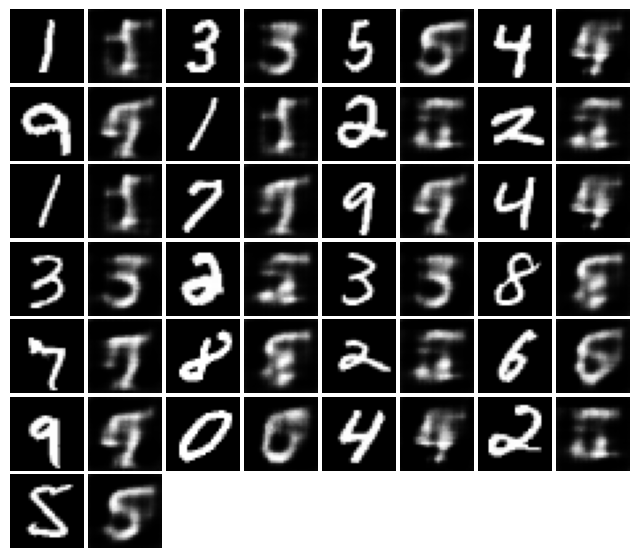

In [16]:
import numpy as np

berton_gan.eval()

latent = berton_gan.face_encoder(img).detach()

print(f'latent vector {latent}')

images = []
for i in np.random.randint(0, len(data), (25,)):
	x_i, y_i = data[i]
	latent_vect = berton_gan.face_encoder(x_i)
	images.append(x_i)
	images.append(
		berton_gan.generate_image_latent(img, latent_vect)
	)

show_images(images, grayscale=True)

In [17]:
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss
from torch.optim import SGD
from tqdm import tqdm

berton_gan = BertonGan()
batch_size = 32
params = list(berton_gan.face_encoder.parameters()) + list(berton_gan.image_decoder.parameters()) + list(berton_gan.image_encoder.parameters())

optimizer = SGD(params, 2e-1)

dataloader = DataLoader(data, batch_size)

for epoch in range(5):
	loss = 0
	for i, dp in tqdm(enumerate(dataloader), total=(len(data) // batch_size)):
		optimizer.zero_grad()
		x, y = dp
		h_F = berton_gan.face_encoder(x)
		h_I = berton_gan.image_encoder(x)
		I_fake = berton_gan.image_decoder(h_I, h_F)
		curr_loss = mse_loss(I_fake, x)
		curr_loss.backward()
		optimizer.step()
		loss += curr_loss.detach()
	print(f'epoch {epoch} has loss {loss}')


  5%|▍         | 90/1875 [00:02<00:52, 34.30it/s]


KeyboardInterrupt: 

In [ ]:
random_idx = torch.randint(0, len(data), (1,))[0]

# get the image and label out
img, label = data[random_idx]

# show the image
print(f'label is a {label}')
show_images([img], grayscale=True)

berton_gan.eval()

with torch.no_grad():
	h_F = berton_gan.face_encoder(img)
	h_I = berton_gan.image_encoder(img)
	I_fake = berton_gan.image_decoder(h_I, h_F)

show_images([I_fake], grayscale=True)